In [16]:
import sqlite3
import pandas as pd
from snowflake.snowpark import Session
import joblib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
conn_sqlite = sqlite3.connect('files/topic_analysis_0.db')
cursor_sqlite = conn_sqlite.cursor()

CONNECTION_PARAMETERS = {}

session = Session.builder.configs(CONNECTION_PARAMETERS).create()

In [18]:
def get_data_iterator():
    data_iterator = session.sql("""SELECT * FROM MODELING.RECOMMENDER_TEST ORDER BY EMAIL""").toLocalIterator()
    return data_iterator

def get_campaign_ids():
    result = session.sql("""SELECT DISTINCT CAMPAIGN_ID, SCORES FROM MODELING.RECOMMENDER_TRAIN""")
    df = result.toPandas()
    df['SCORES'] = df['SCORES'].apply(lambda x: [float(x) for x in x.split(',')])
    return df
def get_feature_list():
    feature_list = {}
    for index, row in get_campaign_ids().iterrows():
        feature_list[row['CAMPAIGN_ID']] = {i: score for i, score in enumerate(row['SCORES'])}
    return feature_list

In [4]:
class LightModel:
        def __init__(self, dataset, model):
            self.dataset = dataset
            self.model = model
    
        def predict(self, new_id, feature_list):
            self.dataset.fit_partial(users=None, items=[new_id])
            item_features = self.dataset.build_item_features(feature_list)
    
            user_mapping = self.dataset.mapping()[0]
            item_mapping = self.dataset.mapping()[2]
    
            all_users = list(user_mapping.values())
            item_expanded = [item_mapping[new_id]] * len(all_users)
            results = self.model.predict(list(user_mapping.values()), item_ids=item_expanded, item_features=item_features, num_threads=12)
    
            all_emails = list(user_mapping.keys())
            
            return list(zip(all_emails, results))

        def predict_all(self, new_ids, emails, feature_list):
            self.dataset.fit_partial(users=None, items=new_ids)
            item_features = self.dataset.build_item_features(feature_list)

            user_mapping = self.dataset.mapping()[0]
            item_mapping = self.dataset.mapping()[2]
            
            user_ids = [user_mapping[email] for email in emails]
            item_ids = [item_mapping[item] for item in new_ids]
            
            results = self.model.predict(user_ids, item_ids=item_ids, item_features=item_features)
            return results

In [5]:
# Getting mean and standard deviation per user
light_model = LightModel(joblib.load('files/dataset.joblib'), joblib.load('files/recommender.joblib'))

feature_list = [(item[0], item[1]) for item in get_feature_list().items()]
results = []

for i in range(12):
    base_topics = [0.0] * 12
    base_topics[i] = 1.0
    new_id = i
    feature_list.append((new_id, {index: num for index, num in enumerate(base_topics)}))
    results.append(light_model.predict(new_id, feature_list))

email_results = {}
for result in results:
    for row in result:
        if row[0] not in email_results:
            email_results[row[0]] = []
        email_results[row[0]].append(row[1])

for email, results in email_results.items():
    email_results[email] = (np.mean(results), np.std(results))

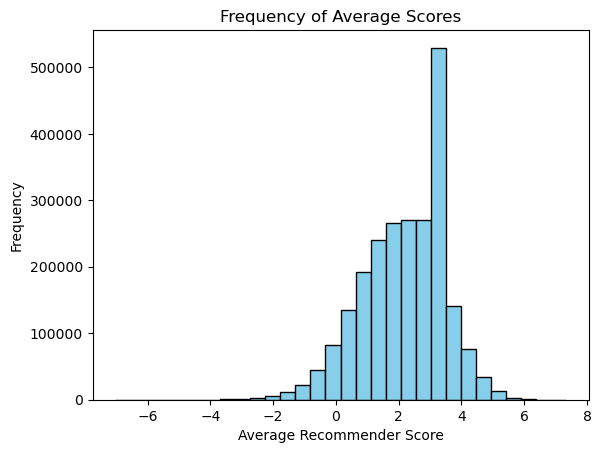

In [6]:
values = [item[0] for item in email_results.values()]
plt.hist(values, bins=30, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Average Recommender Score')
plt.ylabel('Frequency')
plt.title('Frequency of Average Scores')

# Showing the plot
plt.show()

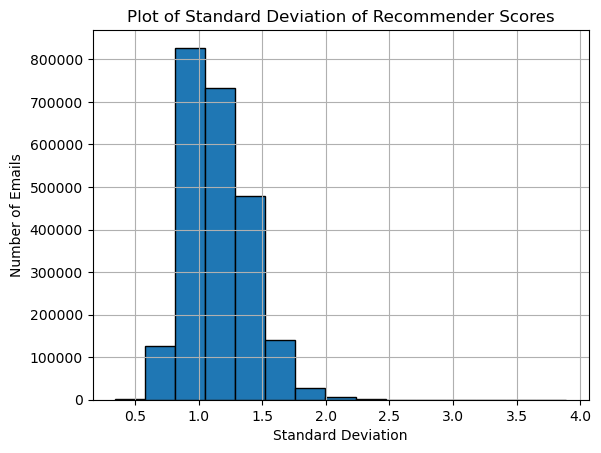

In [7]:
std_deviations = [item[1] for item in email_results.values()]
plt.hist(std_deviations, bins=15, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Standard Deviation')
plt.ylabel('Number of Emails')
plt.title('Plot of Standard Deviation of Recommender Scores')
plt.grid(True)
plt.show()

In [8]:
# Getting the test data and comparing actual actions to what our predictions on those actions would have been
light_model = LightModel(joblib.load('files/dataset.joblib'), joblib.load('files/recommender.joblib'))
emails = []
ids = []
actions = []
feature_list = get_feature_list()

count = 0
data_iterator = get_data_iterator()
email = None

for row in data_iterator:
    if row['EMAIL'] != email:
        email = row['EMAIL']
        count += 1
    if count > 20000:
        break
    if row['CAMPAIGN_ID'] not in feature_list:
        feature_list[row['CAMPAIGN_ID']] = {i: float(score) for i, score in enumerate(row['SCORES'].split(','))}
    emails.append(row['EMAIL'])
    ids.append(row['CAMPAIGN_ID'])
    actions.append(row['ACTION'])
        
results = light_model.predict_all(ids, emails, [(item[0], item[1]) for item in feature_list.items()])

In [9]:
len(results)

1380333

In [10]:
assert len(emails) == len(results)
assert len(results) == len(actions)
result_dict = {}

for pred, email, action in zip(results.tolist(), emails, actions):
    if email not in result_dict:
        result_dict[email] = {'no_action':[], 'action':[]}

    if action == 0:
        result_dict[email]['no_action'].append(pred)
    else:
        result_dict[email]['action'].append(pred)

In [11]:
action_z_scores = []
no_action_z_scores = []

for email, predictions in result_dict.items():
    no_actions = predictions['no_action']
    actions = predictions['action']
    for no_action in no_actions:
        no_action_z_scores.append((no_action - email_results[email][0]) / email_results[email][1])
    for action in actions:
        action_z_scores.append((action - email_results[email][0]) / email_results[email][1])

Average Action Z-Score: 0.4275233445991973


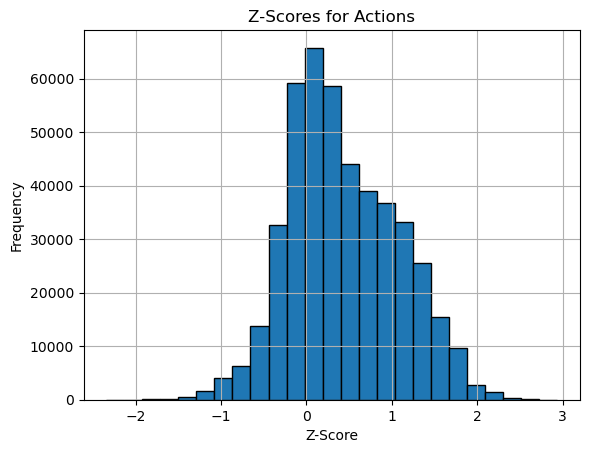

In [14]:
print(f'Average Action Z-Score: {np.mean(action_z_scores)}')
plt.hist(action_z_scores, bins=25, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.title('Z-Scores for Actions')
plt.grid(True)
plt.show()

Average No-Action Z-Score: 0.3334070894888654


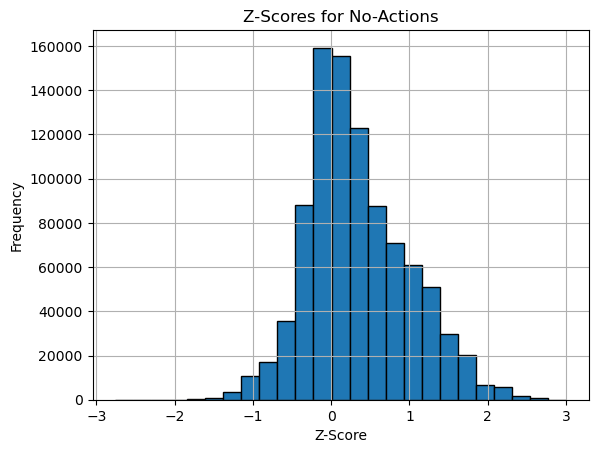

In [15]:
print(f'Average No-Action Z-Score: {np.mean(no_action_z_scores)}')
plt.hist(no_action_z_scores, bins=25, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.title('Z-Scores for No-Actions')
plt.grid(True)
plt.show()